In [1]:
from Pipeline import WifiPipeline, BLEPipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random, time

from imblearn.over_sampling import RandomOverSampler, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Wi-Fi

## Original dataset

In [8]:
# Create original dataset
w = WifiPipeline()
df = w.make_dataframe()

Router     101880
Mini        75782
Dropcam     45912
Kasa        17156
Netcam2      3056
Netcam3      2961
Netcam1      2314
Switch2      2204
Switch1      1963
Switch3      1955
Insight      1738
Switch4      1504
Lifx2         545
Lifx1         495
TpPlug        366
TpBulb        191
Name: Name, dtype: int64


In [43]:
# Remove router from df
df = df[df["DeviceType"]!="router"]

# Only resample training set
df_train = df[df["Set"]=="train"]

### Imbalance by DeviceType

In [224]:
# Print out numbers
print df_train["DeviceType"].value_counts()
print len(df_train)

plug      83642
camera    51282
bulb        686
Name: DeviceType, dtype: int64
135610


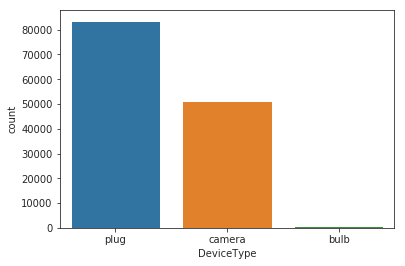

In [46]:
# Create graph of imbalance of original dataset
sns.countplot(x=df_train["DeviceType"]);

### Imbalance by Name (only for information)

In [47]:
# Print out numbers
df_train["Name"].value_counts()

Mini       75782
Dropcam    45912
Netcam2     3056
Netcam1     2314
Switch2     2204
Switch1     1963
Switch3     1955
Insight     1738
Lifx1        495
TpBulb       191
Name: Name, dtype: int64

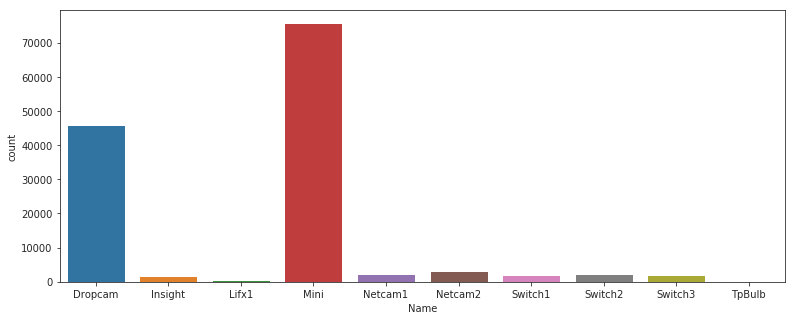

In [48]:
# Create graph of imbalance of original dataset
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(13, 5)
sns.countplot(x=df_train["Name"], 
              order=sorted(df_train["Name"].value_counts().index));

## Create resampled datasets

In [202]:
# List variables that do not work with resampling methods
dataframe_vars = {'Name', 'SourceAddr', 'Set', 'SubtypeNum'}
onehotEncoded_vars = {'Belkin', 'Data', 'Dropcam', 
                      'Lifi', 'Netgear', 'QoS_Data', 
                      'QoS_Null', 'Tp-link'}
response_vars = {"DeviceType","bulb","camera","router","plug"}

# Prep X, y
y = df_train["DeviceType"]
col_drop = response_vars | dataframe_vars | set(['Subtype', 'Vendor'])
X = df_train.drop(col_drop, axis=1)

### Random Up-sampling

In [315]:
rus = RandomOverSampler()
X_upsampled, y_upsampled = rus.fit_resample(X, y)

In [316]:
print len(X_upsampled)

250926


### Random Down-sampling

In [337]:
rds = RandomUnderSampler()
X_downsampled, y_downsampled = rds.fit_resample(X, y)

In [339]:
print len(y_downsampled)

array([['bulb'],
       ['bulb'],
       ['bulb'],
       ...,
       ['plug'],
       ['plug'],
       ['plug']], dtype=object)

### SMOTE

In [343]:
# Get indices of categorical variables
cat_vars = [X.columns.get_loc('Vendor'), X.columns.get_loc('Subtype')]

In [344]:
smote = SMOTENC(categorical_features=cat_vars)
X_smote, y_smote = smote.fit_resample(X, y)

In [207]:
print len(X_smote)

250926


## Evaluate datasets

In [280]:
# Random forests
rf = RandomForestClassifier()

In [37]:
def get_cross_val(rf, X, y):
    # Onehot encode DeviceType
    y_sample = pd.DataFrame(data=y, columns=['DeviceType'])
    deviceType_series = pd.get_dummies(y_sample["DeviceType"])
    y_sample = pd.concat([y_sample, deviceType_series], axis=1)
    y_sample = y_sample.drop('DeviceType', axis=1)
    
    # Extract the three classes as positive class
    devicetype_list = y_sample.columns.unique()
    y_posclasses = [y_sample[devicetype] for devicetype in devicetype_list]
    
    # Run cross-val
    return [cross_validate(rf, X, y_class, scoring='roc_auc',
                           cv=10, return_train_score=False) 
            for y_class in y_posclasses]
    

In [376]:
scores_original = get_cross_val(rf, X, y)

Index([u'bulb', u'camera', u'plug'], dtype='object')


In [332]:
scores_upsampled = get_cross_val(rf, X_upsampled, y_upsampled)

In [341]:
scores_downsampled = get_cross_val(rf, X_downsampled, y_downsampled)

In [345]:
scores_smote = get_cross_val(rf, X_smote, y_smote)

## Find best average AUC

In [378]:
scores = [scores_original, scores_upsampled, 
          scores_downsampled, scores_smote]
sample_names = ['Original', 'Upsampled', 'Downsampled', 'SMOTE']

In [373]:
device_scores = {}
for score,sample in zip(scores,sample_names):
    s = [np.mean(score[x]['test_score']) for x in range(0, len(score))]
    s.append(np.mean(s))
    device_scores[sample] = s

In [385]:
score_names = ['Bulb', 'Camera', 'Plug', 'Average']
for k,v in device_scores.iteritems():
    print k
    for i,score in enumerate(v):
        print score_names[i], ": ", score
    print ""

Downsampled
Bulb :  0.9999365280863218
Camera :  0.990786572173058
Plug :  0.9932208954716424
Average :  0.9946479985770074

Upsampled
Bulb :  1.0
Camera :  0.9869620803982941
Plug :  0.9915280233264697
Average :  0.9928300345749212

Original
Bulb :  1.0
Camera :  0.9451202347596848
Plug :  0.9494874303397282
Average :  0.9648692216998044

SMOTE
Bulb :  1.0
Camera :  0.9811078776261573
Plug :  0.9862963529742628
Average :  0.9891347435334733



# BLE

In [10]:
# Create original dataset
b = BLEPipeline()
b.extract_packet_features(create_master=True)
df = b.make_dataframe()

Old ./BLE_Source deleted
Total number of packets processed:  4010153
Total data processing time:  4120.18242693
Normalized total processing time per 25k packets:  25.6859428239
Total capture file processing time:  705.150784492
Normalized capture file processing time:  4.39603416935
August2    210644
Home1       54902
Home2       54516
Push        30661
Kevo        19430
August1     15047
Weather      8101
Room2        7698
Room1        7239
Door1        6696
Door2        3587
Name: Name, dtype: int64


In [11]:
# Remove router from df
df = df[df["DeviceType"]!="router"]

# Only resample training set
df_train = df[df["Set"]=="train"]

### Imbalance by DeviceType

In [12]:
# Print out numbers
print df_train["DeviceType"].value_counts()
print len(df_train)

door    116114
temp     46001
lock     34477
Name: DeviceType, dtype: int64
196592


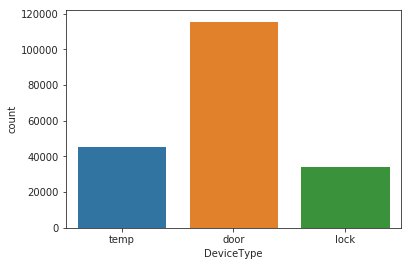

In [13]:
# Create graph of imbalance of original dataset
sns.countplot(x=df_train["DeviceType"]);

### Imbalance by Name (only for information)

In [14]:
# Print out numbers
df_train["Name"].value_counts()

Home1      54902
Home2      54516
Push       30661
Kevo       19430
August1    15047
Weather     8101
Room1       7239
Door1       6696
Name: Name, dtype: int64

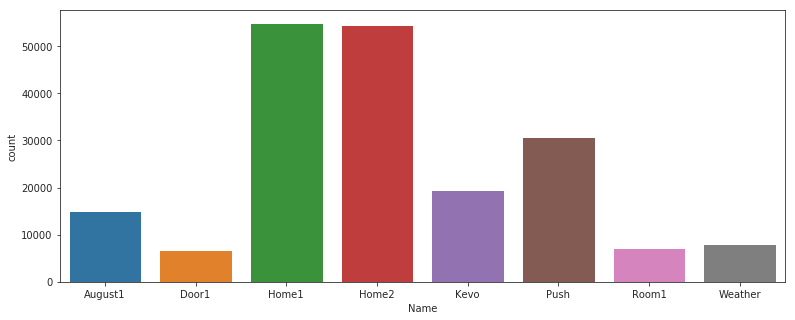

In [15]:
# Create graph of imbalance of original dataset
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(13, 5)
sns.countplot(x=df_train["Name"], 
              order=sorted(df_train["Name"].value_counts().index));

## Create resampled datasets

In [70]:
# List variables that do not work with resampling methods
dataframe_vars = {'Name', 'DeviceName', 'Set', 
                  'AccessAddr', 'AdvertAddr','PDUTypeNum'}
onehotEncoded_vars = {'ADV_DIRECT_IND', 'ADV_IND', 
                      'ADV_NONCONN_IND', 'ADV_SCAN_IND', 
                      'CONNECT_REQ', 'SCAN_REQ', 'SCAN_RSP'}
response_vars = {"DeviceType","door","lock","temp"}

# Prep X, y
y = df_train["DeviceType"]
col_drop = response_vars | dataframe_vars | onehotEncoded_vars
X = df_train.drop(col_drop, axis=1)

In [119]:
X.columns

Index([u'BLE_LL_Length', u'RFChannel', u'PacketLength', u'Time', u'PDUType',
       u'Assoc_Packets'],
      dtype='object')

### Random Up-sampling

In [72]:
rus = RandomOverSampler()
X_upsampled, y_upsampled = rus.fit_resample(X, y)

In [73]:
print len(X_upsampled)

348342


### Random Down-sampling

In [74]:
rds = RandomUnderSampler()
X_downsampled, y_downsampled = rds.fit_resample(X, y)

In [75]:
print len(X_downsampled)

103431


### SMOTE

In [77]:
# Get indices of categorical variables
cat_vars = [X.columns.get_loc('RFChannel'), X.columns.get_loc('PDUType')]
cat_vars

[1, 4]

In [78]:
smote = SMOTENC(categorical_features=cat_vars)
X_smote, y_smote = smote.fit_resample(X, y)

In [79]:
print len(X_smote)

348342


## Evaluate datasets

In [85]:
# Random forests
rf = RandomForestClassifier()

In [124]:
def ble_get_cross_val(rf, X, y):
    # Onehot encode DeviceType
    y_sample = pd.DataFrame(data=y, columns=['DeviceType'])
    deviceType_series = pd.get_dummies(y_sample["DeviceType"])
    y_sample = pd.concat([y_sample, deviceType_series], axis=1)
    y_sample = y_sample.drop('DeviceType', axis=1)
    
    # Onehot encode RFChannel and PDUType
    X = pd.DataFrame(data=X, 
                     columns=['BLE_LL_Length', 
                              'RFChannel', 'PacketLength', 
                              'Time', 'PDUType','Assoc_Packets'])
    rfchannel_series = pd.get_dummies(X["RFChannel"])
    pdutype_series = pd.get_dummies(X["PDUType"])
    X = pd.concat([X, rfchannel_series, pdutype_series], axis=1)
    X = X.drop(['RFChannel','PDUType'], axis=1)
    
    # Extract the three classes as positive class
    devicetype_list = y_sample.columns.unique()
    y_posclasses = [y_sample[devicetype] for devicetype in devicetype_list]
    
    # Run cross-val
    return [cross_validate(rf, X, y_class, scoring='roc_auc', 
                           cv=10, return_train_score=False) 
            for y_class in y_posclasses]
    

In [125]:
ble_scores_original = ble_get_cross_val(rf, X, y)

In [111]:
ble_scores_upsampled = ble_get_cross_val(rf, X_upsampled, y_upsampled)

In [112]:
ble_scores_downsampled = ble_get_cross_val(rf, X_downsampled, y_downsampled)

In [113]:
ble_scores_smote = ble_get_cross_val(rf, X_smote, y_smote)

## Find best average AUC

In [116]:
ble_scores = [ble_scores_original, ble_scores_upsampled, 
              ble_scores_downsampled, ble_scores_smote]
sample_names = ['Original', 'Upsampled', 'Downsampled', 'SMOTE']

In [117]:
ble_device_scores = {}
for score,sample in zip(ble_scores,sample_names):
    s = [np.mean(score[x]['test_score']) for x in range(0, len(score))]
    s.append(np.mean(s))
    ble_device_scores[sample] = s

In [126]:
score_names = ['Door', 'Lock', 'Temp', 'Average']
for k,v in ble_device_scores.iteritems():
    print k
    for i,score in enumerate(v):
        print score_names[i], ": ", score
    print ""

Downsampled
Door :  0.9916639889102734
Lock :  0.999911798475855
Temp :  0.9970958424565957
Average :  0.9962238766142413

Upsampled
Door :  0.9708653280353478
Lock :  0.99999129420772
Temp :  0.9854206180372772
Average :  0.985425746760115

Original
Door :  0.8928115981592329
Lock :  0.999880089449217
Temp :  0.9202294313035818
Average :  0.9376403729706771

SMOTE
Door :  0.9708287717684806
Lock :  0.9999245722814207
Temp :  0.9850336204031054
Average :  0.9852623214843356

